Use this notebook to train the autoencoder and to perform some visuaizations on the latent representation resulting from the encoder.

In [1]:
# !pip install package_name

In [2]:
# Packages needeed for training the atuoencoder
# Command to install library -> !pip install package_name

import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 # to install -> !pip install opencv-python
from tqdm import tqdm
import random

import keras
from keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Conv2DTranspose, Dropout

2022-11-16 22:17:06.016701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Function to load Data
# img_folder should contain sub-folders with images from different classes
#
#     The function returns the images in your directories as arrays and
#     an array contain each image class name, which correspond to the sub-folders names

def create_dataset(img_folder):
    img_data_array = []
    class_name = []

    for dir1 in tqdm(os.listdir(img_folder)):
        if dir1 == '.DS_Store':
            continue
        else:
            for file in os.listdir(os.path.join(img_folder, dir1)):
                image_path = os.path.join(img_folder, dir1, file)
                image = cv2.imread(image_path)[:,:,::-1]
                image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)
                image = np.array(image)
                image = image.astype('float32')
                image /= 255
                img_data_array.append(image)
                class_name.append(dir1)
    return img_data_array, class_name

In [4]:
# Define the path to your data and the image size
# Changing the image dimensions requires to adapt the autoencoder architecture
img_folder = 'photobox_sample/Reduced_Dataset/output'
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Write your model name
model_name = 'size_128_dim_512'

In [5]:
# extract the image array and class name
img_data, class_name = create_dataset(img_folder)

# Dictionary for class names
target_dict = {k: v for v, k in enumerate(np.unique(class_name))}

# convert class_names to numeric values
target_val = [target_dict[class_name[i]] for i in range(len(class_name))]

100%|█████████████████████████████████████████████| 9/9 [00:45<00:00,  5.08s/it]


In [6]:
# Shuffle data and create train-val datasets

# As list and shuffle
img_data = np.asarray(img_data)
zipped = list(zip(img_data,target_val))

random.seed(10)
random.shuffle(zipped)
img_data, target_val = zip(*zipped)

# train and test sets
split_ratio = 0.85
X_train = np.asarray(img_data[:int(split_ratio*len(img_data))])
X_val = np.asarray(img_data[int(split_ratio*len(img_data)):])
y_val = np.asarray(target_val[int(split_ratio*len(img_data)):])

#Image Dimension
IMAGE_DIM=X_train.shape[1:]
print('Image Dim: ')
print(IMAGE_DIM)

Image Dim: 
(128, 128, 3)


In [7]:
# Autoencoder 
# Architecture still needs a lot of tuning

def ConvAutoEncoder(img_dim, encoded_size):
    #Encoder Part
    enc = keras.models.Sequential()
    enc.add(InputLayer(img_dim))
    enc.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    enc.add(MaxPooling2D(pool_size=(2, 2))) 
    enc.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    enc.add(MaxPooling2D(pool_size=(2, 2)))
    enc.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    enc.add(MaxPooling2D(pool_size=(2, 2)))
    enc.add(Flatten())
    enc.add(Dense(ENCODED_SIZE))

    #Decoder Part
    dec = keras.models.Sequential()
    dec.add(InputLayer((encoded_size,)))
    dec.add(Dense(4096))
    dec.add(Reshape((8,8,64)))
    dec.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    dec.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    dec.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    dec.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))

    return enc, dec

In [8]:
#Required Feature vector size after encoding
ENCODED_SIZE = 512

# Build models
encoder, decoder = ConvAutoEncoder(img_dim=IMAGE_DIM, encoded_size=ENCODED_SIZE)

#Print Summary
encoder.summary()
decoder.summary()

2022-11-16 22:19:10.867959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

Epoch 1/30
1063/1063 [==============================] - 715s 671ms/step - loss: 0.0091 - val_loss: 0.0028
Epoch 2/30
1063/1063 [==============================] - 818s 770ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 3/30
1063/1063 [==============================] - 778s 732ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 4/30
1063/1063 [==============================] - 719s 676ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/30
1063/1063 [==============================] - 833s 783ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 6/30
1063/1063 [==============================] - 792s 745ms/step - loss: 9.4226e-04 - val_loss: 8.4785e-04
Epoch 7/30
1063/1063 [==============================] - 675s 635ms/step - loss: 8.3171e-04 - val_loss: 8.0644e-04
Epoch 8/30
1063/1063 [==============================] - 805s 757ms/step - loss: 7.6908e-04 - val_loss: 7.1480e-04
Epoch 9/30
1063/1063 [==============================] - 826s 777ms/step - loss: 7.1050e-04 - val_loss: 6.6252e-04
Epoch 10/30
10

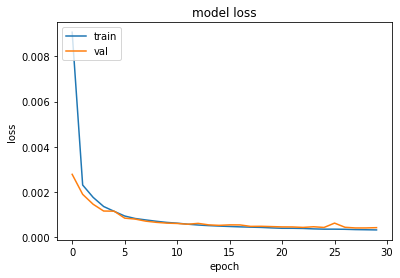

In [9]:
# Train the autoencoder
EPOCHS = 30

input = Input(IMAGE_DIM)
encoded = encoder(input)
decoded = decoder(encoded)

cae = keras.models.Model(inputs=input, outputs=decoded)
cae.compile(optimizer='adamax', loss='mean_squared_error')

history = cae.fit(X_train, X_train, batch_size=16, epochs=EPOCHS, verbose=1, validation_data=(X_val, X_val))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Save models for later use                       
cae.save('convAutoEncoder_' + model_name + '.h5')
encoder.save('encoder_' + model_name + '.h5')
decoder.save('decoder_' + model_name + '.h5')

In [10]:
# Some util functions
def show_image(x):
    plt.imshow(np.clip(x, 0, 1))

def display_input_output(image):
    encoded_vector = encoder.predict(image[np.newaxis, :])[0]
    decoded_image = decoder.predict(encoded_vector[np.newaxis, :])[0]

    plt.subplot(1, 2, 1)
    plt.title("Input_Image")
    show_image(image)

    plt.subplot(1, 2, 2)
    plt.title("Output_Image")
    show_image(decoded_image)

    plt.show()

1/1 [==============================] - 1s 716ms/step


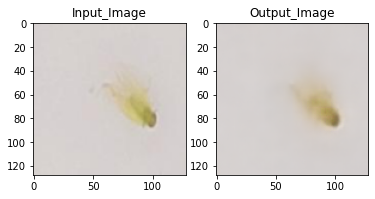

1/1 [==============================] - 0s 42ms/step


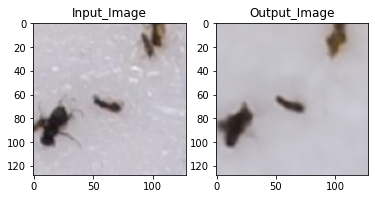

1/1 [==============================] - 0s 47ms/step


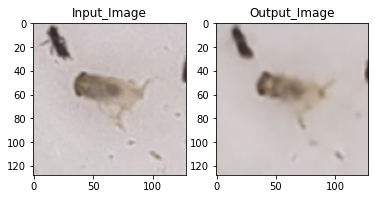

1/1 [==============================] - 0s 116ms/step


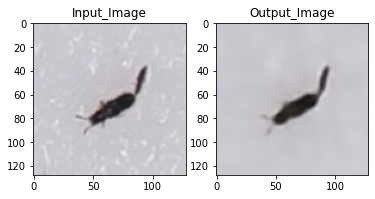

In [11]:
# Display Random Val Images with both Input_Image as well as Reconstructed/Decoded Image
for i in range(4):
    rand_idx = np.random.randint(0, X_val.shape[0])
    test_image = X_val[rand_idx]
    display_input_output(test_image)

Once the model is trained, we applied some visualization techniques for high dimensional data.

In [12]:
# Load models if not trained
encoder = keras.models.load_model('encoder_' + model_name + '.h5')
decoder = keras.models.load_model('encoder_' + model_name + '.h5')

# Compress val data
X_val_compressed = encoder.predict(X_val)

94/94 [==============================] - 22s 233ms/step


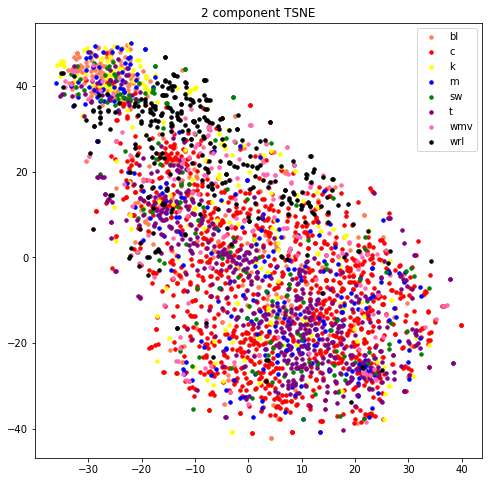

In [13]:
# TSNE

from sklearn.manifold import TSNE
color_dict = { 0: '#ff7f50', 1: 'red', 2: 'yellow',3: 'blue', 4: 'green', 5: 'purple', 6: '#ff69b4', 7: 'black', 8: 'cyan', 9: 'magenta', 10: '#faebd7', 11: '#2e8b57', 12: '#eeefff', 13: '#da70d6'}

tsne = TSNE(n_components=2)
X_val_2D = tsne.fit_transform(X_val_compressed)
inv_dict = {v: k for k, v in target_dict.items()}

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1)
for g in np.unique(y_val):
    ix = np.where(y_val == g)
    ax.scatter(X_val_2D[ix,0], X_val_2D[ix,1], c = color_dict[g], label = inv_dict[g], s = 12)

ax.set_title('2 component TSNE')
ax.legend()
plt.show()

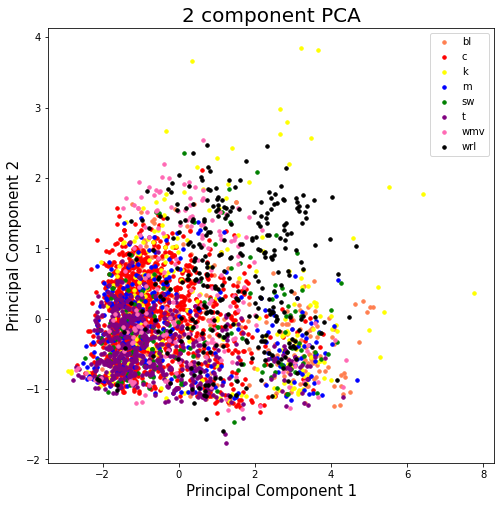

In [14]:
# PCA

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_val_compressed)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = np.unique(y_val)
colors = color_dict

for g in np.unique(y_val):
    ix = np.where(y_val == g)
    ax.scatter(principalComponents[ix,0], principalComponents[ix,1], c = color_dict[g], label = inv_dict[g], s = 12)
ax.legend()
plt.show()

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


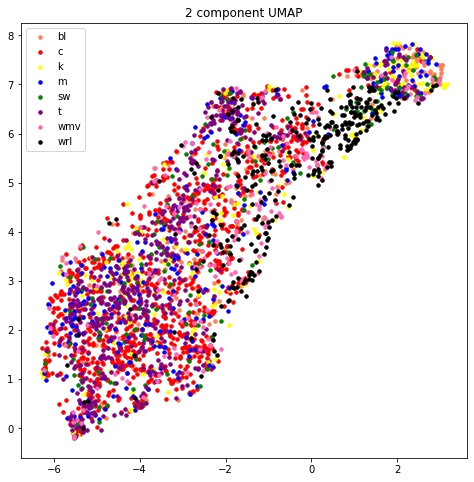

In [15]:
# UMAP

import seaborn as sns
import umap

fit = umap.UMAP()
u = fit.fit_transform(X_val_compressed)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1)
for g in np.unique(y_val):
    ix = np.where(y_val == g)
    ax.scatter(u[ix,0], u[ix,1], c = color_dict[g], label = inv_dict[g], s = 12)

ax.set_title('2 component UMAP')
ax.legend()
plt.show()